In [1]:
import matplotlib.pyplot as plt
import os 
from PIL import Image
import pandas as pd
from torchvision import transforms, models
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import decoders
from base import resnet 
import metrics
%matplotlib inline

**1.** Download the data from https://drive.google.com/drive/folders/1GDL1pvlDCcsyEwafe7N41WtS7doFlju3, and unzip the folder. You should have three folders: imgs with the satellite images, masks and masks_filled with the respective masks, either as delineated boundaries, or filled segmentation masks.

**2.** Using subplots, plot 5 example images and their respective masks

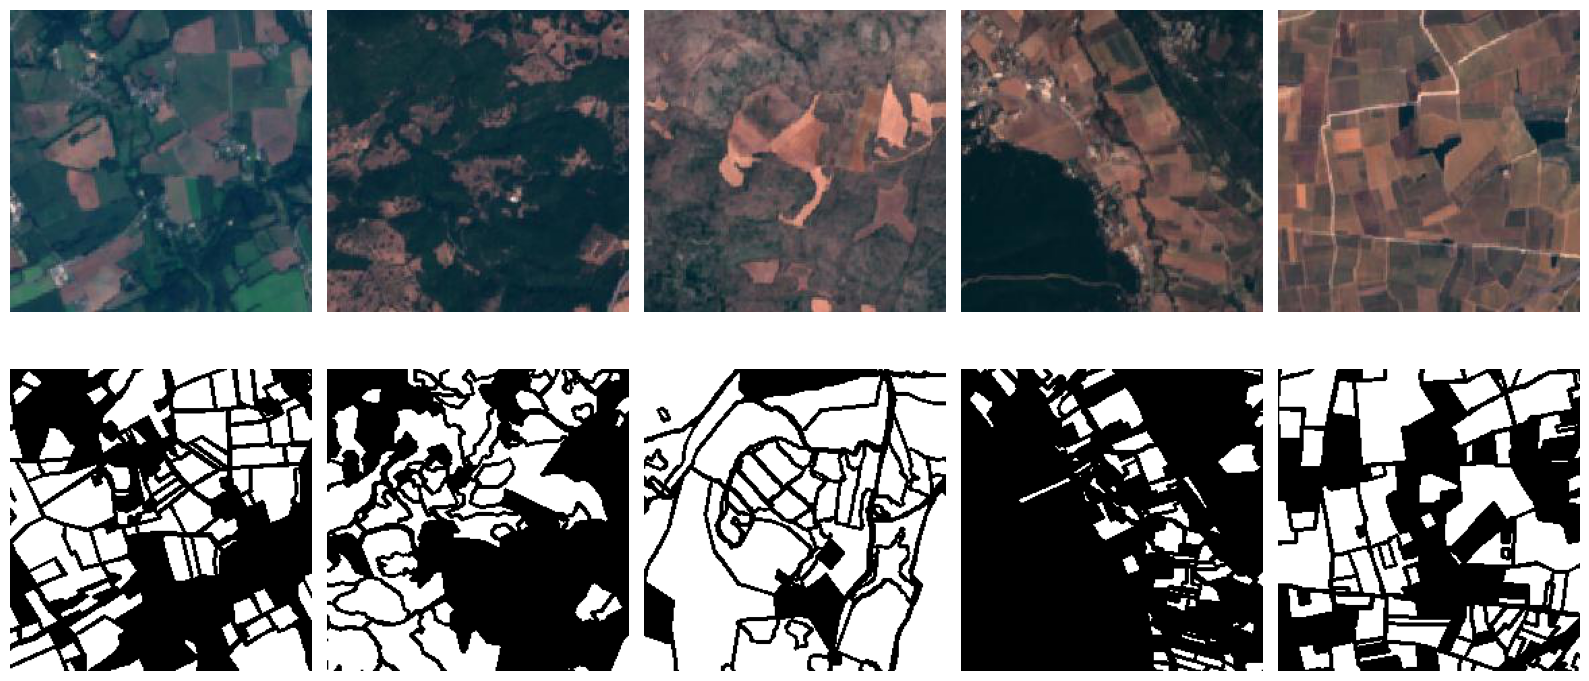

In [3]:
imgs_path = "crop_delineation/imgs"
imgs = sorted(os.listdir(imgs_path))
masks_path = "crop_delineation/masks_filled"
masks = sorted(os.listdir(masks_path))

rows, cols = 2, 5

fig, axs = plt.subplots(rows, cols, figsize=(16, 8))
for row in range(rows):
    for col in range(cols):
        if row == 0:
            img = Image.open(os.path.join(imgs_path, imgs[col]))
            axs[row, col].imshow(img)
            axs[row, col].axis('off')
        else:
            mask = Image.open(os.path.join(masks_path, masks[col]))
            axs[row, col].imshow(mask, cmap='gray')
            axs[row, col].axis('off')
plt.tight_layout()
plt.show()
        

**3.** Make a dataloader to prepare data for training

In [4]:
# Create custom DataLoader class

class CropDelineationDataset(Dataset):
    def __init__(self, csv_file, img_dir, mask_dir, split, transform=None, img_transform=None, mask_transform=None):
        self.data_frame = pd.read_csv(csv_file)
        self.data_frame = self.data_frame[self.data_frame['split'] == split]
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.img_transform = img_transform
        self.mask_transform = mask_transform

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, str(self.data_frame.iloc[idx, 1]) + '.jpeg') 
        mask_name = os.path.join(self.mask_dir, str(self.data_frame.iloc[idx, 1]) + '.png')  

        image = Image.open(img_name).convert('RGB')
        mask = Image.open(mask_name).convert('L')  
        
        if self.img_transform:
            image = self.img_transform(image)
            mask = self.mask_transform(mask)

        return image, mask.type(torch.LongTensor)

mean = [0.2384, 0.2967, 0.3172]
std = [0.1873, 0.1226, 0.1138]

img_transform = transforms.Compose([
    # Add more here if needed, this dataset is already cropped and sized for us
    transforms.ToTensor(),
    transforms.Normalize(mean, std)

])

mask_transform = transforms.Compose([
    # Add more here if needed, this dataset is already cropped and sized for us
    transforms.ToTensor()
])

# Instantiate dataloaders for train and test splits
train_dataset = CropDelineationDataset(csv_file='crop_delineation/clean_data.csv',
                              img_dir='crop_delineation/imgs',
                              mask_dir='crop_delineation/masks_filled',
                              split='train',
                              transform=True,
                              img_transform=img_transform,
                              mask_transform=mask_transform)

val_dataset = CropDelineationDataset(csv_file='crop_delineation/clean_data.csv',
                              img_dir='crop_delineation/imgs',
                              mask_dir='crop_delineation/masks_filled',
                              split='val',
                              transform=True,
                              img_transform=img_transform,
                              mask_transform=mask_transform)

test_dataset = CropDelineationDataset(csv_file='crop_delineation/clean_data.csv',
                             img_dir='crop_delineation/imgs',
                             mask_dir='crop_delineation/masks_filled',
                             split='test',
                             transform=True,
                             img_transform=img_transform,
                             mask_transform=mask_transform)


batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
# drop_last drops the last batch if it's not big enough, otherwise the training could be spoiled
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

Show examples from the dataloader to make sure it works

In [10]:
def plot_examples(data_loader, num_examples=3):
    fig, axs = plt.subplots(2, num_examples, figsize=(num_examples*2, 4))
    for i, (image, mask) in enumerate(data_loader):
        if i >= num_examples:
            break
        # image, mask now contains batch_size images and masks, we only plot the first element of the batch
        axs[0, i].imshow(image[0].permute(1, 2, 0))
        axs[0, i].axis('off')
        
        axs[1, i].imshow(mask[0].squeeze(), cmap='gray')
        axs[1, i].axis('off')
    
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


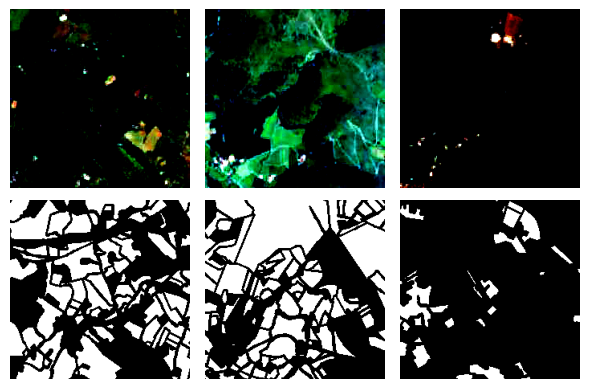

In [11]:
plot_examples(train_loader)

Looks weird right? That's because we've normalized the data, we need to "undo" the normalization if we want to visualize the images correctly. However, we want to feed the model normalized images because it speeds up convergence

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


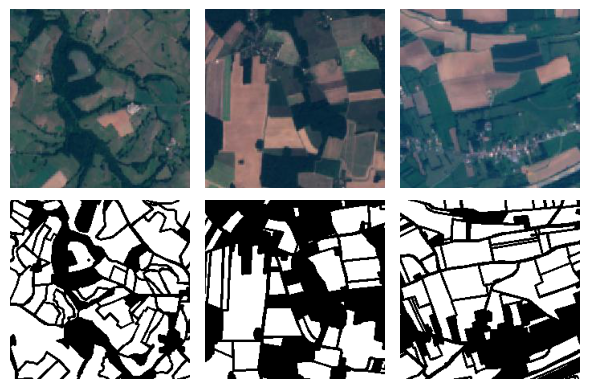

In [13]:
def plot_examples(data_loader, inv_trans, num_examples=3):
    fig, axs = plt.subplots(2, num_examples, figsize=(num_examples*2, 4))
    for i, (image, mask) in enumerate(data_loader):
        if i >= num_examples:
            break
        # image, mask now contains batch_size images and masks, we only plot the first element of the batch
        axs[0, i].imshow(inv_trans(image[0]).permute(1, 2, 0))
        axs[0, i].axis('off')
        
        axs[1, i].imshow(mask[0].squeeze(), cmap='gray')
        axs[1, i].axis('off')
    
    plt.tight_layout()
    plt.show()

invTrans = transforms.Compose([transforms.Normalize(mean = [-mean[i]/std[i] for i in range(3)],
                                                    std = [1/std[i] for i in range(3) ]),])

plot_examples(train_loader, invTrans)

**4.** Take an pre-trained resnet50 encoder and add a segmentation head on top. 

In [14]:
pretrained_r50 = models.resnet50(pretrained=True)
state_dict = pretrained_r50.state_dict()
state_dict.pop("fc.weight")
state_dict.pop("fc.bias")
encoder = resnet.resnet50(inter_features=True)
encoder.load_state_dict(state_dict, strict=True)
decoder = decoders.load(decoder_name="unet", encoder=encoder) 

/home/bogdan.boskovic/miniconda3/envs/dl/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/bogdan.boskovic/miniconda3/envs/dl/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


**5.** Fine-tune the model on the training data

**a.** Train with frozen encoder

In [15]:
fine_tune_encoder = False
if fine_tune_encoder:
    # Chain the iterators to combine them.
    params = list(encoder.parameters())+list(decoder.parameters())
else:
    params = decoder.parameters()

optimizer = torch.optim.Adam(params, lr=1e-3)
criterion = nn.BCEWithLogitsLoss()



In [17]:
def train(encoder, decoder, device, epochs=20, fine_tune_encoder=False):
    encoder.to(device)
    decoder.to(device)
    
    if fine_tune_encoder:
        encoder.train()
    else:
        encoder.eval()
   
    decoder.train()
    criterion = metrics.load(metric_name = "softiouloss", device=device)
    acc_metric = metrics.load(metric_name = "iou", device=device)

    criterion.to(device)

    for epoch in tqdm(range(epochs)):
    
        running_loss = 0.0
        running_acc = 0.0
        
        for batch_idx, (images, masks) in tqdm(enumerate(train_loader)):
            images = images.to(device)
            masks = masks.to(device)
            
            #Forward pass
            if fine_tune_encoder:
                outputs = encoder(images)
            else:
                with torch.no_grad():
                    outputs = encoder(images)
            outputs = decoder(outputs)
            loss = criterion(outputs, masks)
            
            pred_logits = torch.sigmoid(outputs)  # Sigmoid activation function
            pred_masks = (pred_logits > 0.5).long() 

            acc = acc_metric(pred_masks, masks)
            if batch_idx % 10 == 0:
                print(f"\t Train Loss: {loss.item():.4f}. Train Accuracy {acc.item():.4f}")
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()

            running_loss += loss.item()
            running_acc += acc.item()

            optimizer.step()

        
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = running_acc / len(train_loader)

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}; Acc: {epoch_acc:.4f}")


In [18]:
train(encoder=encoder, decoder=decoder, device="cuda:0", epochs=20, fine_tune_encoder=False)

  0%|          | 0/20 [00:00<?, ?it/s]

	 Train Loss: 0.5068. Train Accuracy 0.2757


	 Train Loss: 0.3940. Train Accuracy 0.4485


	 Train Loss: 0.3896. Train Accuracy 0.4180


	 Train Loss: 0.3705. Train Accuracy 0.4581


	 Train Loss: 0.3116. Train Accuracy 0.5207


50it [00:13,  3.75it/s]
  5%|▌         | 1/20 [00:13<04:13, 13.35s/it]

Epoch [1/20], Loss: 0.3708; Acc: 0.4491


	 Train Loss: 0.3226. Train Accuracy 0.5003


	 Train Loss: 0.3579. Train Accuracy 0.4504


	 Train Loss: 0.2923. Train Accuracy 0.5128


	 Train Loss: 0.2943. Train Accuracy 0.5550


	 Train Loss: 0.2838. Train Accuracy 0.5634


50it [00:13,  3.84it/s]
 10%|█         | 2/20 [00:26<03:56, 13.16s/it]

Epoch [2/20], Loss: 0.2937; Acc: 0.5360


	 Train Loss: 0.2657. Train Accuracy 0.5675


	 Train Loss: 0.2822. Train Accuracy 0.5193


	 Train Loss: 0.2308. Train Accuracy 0.6223


	 Train Loss: 0.2921. Train Accuracy 0.5237


	 Train Loss: 0.2487. Train Accuracy 0.5697


50it [00:12,  4.10it/s]
 15%|█▌        | 3/20 [00:38<03:36, 12.72s/it]

Epoch [3/20], Loss: 0.2578; Acc: 0.5766


	 Train Loss: 0.2813. Train Accuracy 0.5582


	 Train Loss: 0.2614. Train Accuracy 0.5542


	 Train Loss: 0.2501. Train Accuracy 0.5711


	 Train Loss: 0.2608. Train Accuracy 0.5841


	 Train Loss: 0.2625. Train Accuracy 0.5741


50it [00:12,  4.11it/s]
 20%|██        | 4/20 [00:50<03:20, 12.51s/it]

Epoch [4/20], Loss: 0.2541; Acc: 0.5822


	 Train Loss: 0.2494. Train Accuracy 0.5931


	 Train Loss: 0.2601. Train Accuracy 0.5757


	 Train Loss: 0.2584. Train Accuracy 0.5760


	 Train Loss: 0.2343. Train Accuracy 0.6071


	 Train Loss: 0.2503. Train Accuracy 0.5618


50it [00:12,  4.04it/s]
 25%|██▌       | 5/20 [01:03<03:07, 12.47s/it]

Epoch [5/20], Loss: 0.2548; Acc: 0.5828


	 Train Loss: 0.2630. Train Accuracy 0.5817


	 Train Loss: 0.2174. Train Accuracy 0.6135


	 Train Loss: 0.2240. Train Accuracy 0.6249


	 Train Loss: 0.2298. Train Accuracy 0.6098


	 Train Loss: 0.2425. Train Accuracy 0.6051


50it [00:12,  4.08it/s]
 30%|███       | 6/20 [01:15<02:53, 12.40s/it]

Epoch [6/20], Loss: 0.2374; Acc: 0.6024


	 Train Loss: 0.2344. Train Accuracy 0.6022


	 Train Loss: 0.2673. Train Accuracy 0.5693


	 Train Loss: 0.2183. Train Accuracy 0.6318


	 Train Loss: 0.2240. Train Accuracy 0.6218


	 Train Loss: 0.2254. Train Accuracy 0.6252


50it [00:12,  4.08it/s]
 35%|███▌      | 7/20 [01:27<02:40, 12.36s/it]

Epoch [7/20], Loss: 0.2341; Acc: 0.6052


	 Train Loss: 0.2166. Train Accuracy 0.6445


	 Train Loss: 0.2075. Train Accuracy 0.6513


	 Train Loss: 0.2239. Train Accuracy 0.6167


	 Train Loss: 0.2239. Train Accuracy 0.6342


	 Train Loss: 0.2283. Train Accuracy 0.6109


50it [00:12,  4.09it/s]
 40%|████      | 8/20 [01:39<02:27, 12.31s/it]

Epoch [8/20], Loss: 0.2273; Acc: 0.6148


	 Train Loss: 0.2411. Train Accuracy 0.5674


	 Train Loss: 0.2112. Train Accuracy 0.6250


	 Train Loss: 0.2309. Train Accuracy 0.6205


	 Train Loss: 0.2059. Train Accuracy 0.6397


	 Train Loss: 0.2215. Train Accuracy 0.6284


50it [00:12,  4.08it/s]
 45%|████▌     | 9/20 [01:52<02:15, 12.30s/it]

Epoch [9/20], Loss: 0.2240; Acc: 0.6166


	 Train Loss: 0.2181. Train Accuracy 0.6340


	 Train Loss: 0.2349. Train Accuracy 0.6119


	 Train Loss: 0.2168. Train Accuracy 0.6247


	 Train Loss: 0.2160. Train Accuracy 0.6210


	 Train Loss: 0.2008. Train Accuracy 0.6337


50it [00:12,  4.11it/s]
 50%|█████     | 10/20 [02:04<02:02, 12.26s/it]

Epoch [10/20], Loss: 0.2177; Acc: 0.6260


	 Train Loss: 0.2050. Train Accuracy 0.6541


	 Train Loss: 0.2000. Train Accuracy 0.6556


	 Train Loss: 0.2562. Train Accuracy 0.5815


	 Train Loss: 0.2188. Train Accuracy 0.6458


	 Train Loss: 0.2446. Train Accuracy 0.5907


50it [00:12,  4.10it/s]
 55%|█████▌    | 11/20 [02:16<01:50, 12.24s/it]

Epoch [11/20], Loss: 0.2162; Acc: 0.6286


	 Train Loss: 0.2158. Train Accuracy 0.6375


	 Train Loss: 0.1980. Train Accuracy 0.6620


	 Train Loss: 0.2058. Train Accuracy 0.6441


	 Train Loss: 0.1947. Train Accuracy 0.6507


	 Train Loss: 0.2235. Train Accuracy 0.6193


50it [00:12,  4.11it/s]
 60%|██████    | 12/20 [02:28<01:37, 12.22s/it]

Epoch [12/20], Loss: 0.2157; Acc: 0.6294


	 Train Loss: 0.2354. Train Accuracy 0.6077


	 Train Loss: 0.2419. Train Accuracy 0.6168


	 Train Loss: 0.2188. Train Accuracy 0.6332


	 Train Loss: 0.2481. Train Accuracy 0.5718


	 Train Loss: 0.2167. Train Accuracy 0.6385


50it [00:12,  4.13it/s]
 65%|██████▌   | 13/20 [02:40<01:25, 12.19s/it]

Epoch [13/20], Loss: 0.2280; Acc: 0.6137


	 Train Loss: 0.2299. Train Accuracy 0.6099


	 Train Loss: 0.2298. Train Accuracy 0.6128


	 Train Loss: 0.2069. Train Accuracy 0.6428


	 Train Loss: 0.2039. Train Accuracy 0.6394


	 Train Loss: 0.2211. Train Accuracy 0.6168


50it [00:12,  4.12it/s]
 70%|███████   | 14/20 [02:52<01:13, 12.17s/it]

Epoch [14/20], Loss: 0.2182; Acc: 0.6243


	 Train Loss: 0.2253. Train Accuracy 0.5955


	 Train Loss: 0.1794. Train Accuracy 0.6813


	 Train Loss: 0.1837. Train Accuracy 0.6708


	 Train Loss: 0.2086. Train Accuracy 0.6465


	 Train Loss: 0.2034. Train Accuracy 0.6561


50it [00:12,  4.09it/s]
 75%|███████▌  | 15/20 [03:05<01:00, 12.19s/it]

Epoch [15/20], Loss: 0.2094; Acc: 0.6368


	 Train Loss: 0.2246. Train Accuracy 0.6368


	 Train Loss: 0.1900. Train Accuracy 0.6618


	 Train Loss: 0.2183. Train Accuracy 0.6128


	 Train Loss: 0.2018. Train Accuracy 0.6470


	 Train Loss: 0.1986. Train Accuracy 0.6452


50it [00:12,  4.10it/s]
 80%|████████  | 16/20 [03:17<00:48, 12.19s/it]

Epoch [16/20], Loss: 0.2010; Acc: 0.6508


	 Train Loss: 0.2036. Train Accuracy 0.6330


	 Train Loss: 0.2015. Train Accuracy 0.6576


	 Train Loss: 0.2105. Train Accuracy 0.6472


	 Train Loss: 0.2145. Train Accuracy 0.6206


	 Train Loss: 0.1933. Train Accuracy 0.6573


50it [00:12,  4.13it/s]
 85%|████████▌ | 17/20 [03:29<00:36, 12.17s/it]

Epoch [17/20], Loss: 0.1994; Acc: 0.6524


	 Train Loss: 0.1887. Train Accuracy 0.6793


	 Train Loss: 0.1845. Train Accuracy 0.6741


	 Train Loss: 0.2126. Train Accuracy 0.6439


	 Train Loss: 0.1915. Train Accuracy 0.6574


	 Train Loss: 0.1832. Train Accuracy 0.6792


50it [00:12,  4.08it/s]
 90%|█████████ | 18/20 [03:41<00:24, 12.20s/it]

Epoch [18/20], Loss: 0.1982; Acc: 0.6546


	 Train Loss: 0.2077. Train Accuracy 0.6234


	 Train Loss: 0.2021. Train Accuracy 0.6504


	 Train Loss: 0.2155. Train Accuracy 0.6361


	 Train Loss: 0.2109. Train Accuracy 0.6244


	 Train Loss: 0.2111. Train Accuracy 0.6210


50it [00:12,  4.03it/s]
 95%|█████████▌| 19/20 [03:54<00:12, 12.27s/it]

Epoch [19/20], Loss: 0.1995; Acc: 0.6527


	 Train Loss: 0.1920. Train Accuracy 0.6690


	 Train Loss: 0.1792. Train Accuracy 0.6599


	 Train Loss: 0.1849. Train Accuracy 0.6676


	 Train Loss: 0.2046. Train Accuracy 0.6735


	 Train Loss: 0.1888. Train Accuracy 0.6612


50it [00:12,  4.08it/s]
100%|██████████| 20/20 [04:06<00:00, 12.32s/it]

Epoch [20/20], Loss: 0.1935; Acc: 0.6619


In [19]:
torch.save(encoder.state_dict(), "encoder.pt")
torch.save(decoder.state_dict(), "decoder.pt")

**b.** Train the model end-to-end

In [20]:
fine_tune_encoder = True

pretrained_r50 = models.resnet50(pretrained=True)
state_dict = pretrained_r50.state_dict()
state_dict.pop("fc.weight")
state_dict.pop("fc.bias")
encoder = resnet.resnet50(inter_features=True)
encoder.load_state_dict(state_dict, strict=True)
decoder = decoders.load(decoder_name="unet", encoder=encoder) 
if fine_tune_encoder:
    # Chain the iterators to combine them.
    params = list(encoder.parameters())+list(decoder.parameters())
else:
    params = decoder.parameters()
#train(encoder=encoder, decoder=decoder, epochs=20, fine_tune_encoder=fine_tune_encoder)

**6.** Evaluate both models on examples from the test set

In [21]:
encoder.load_state_dict(torch.load("./encoder.pt"))
decoder.load_state_dict(torch.load("./decoder.pt"))

<All keys matched successfully>

In [22]:
def plot_predictions(images, masks, preds, inv_trans, num_examples=3):
    fig, axs = plt.subplots(num_examples, 3, figsize=(10, num_examples * 3))
    for i in range(num_examples):
        axs[i, 0].imshow(inv_trans(images[i]).cpu().numpy().transpose((1, 2, 0)))
        axs[i, 0].set_title('Input Image')
        axs[i, 1].imshow(masks[i].cpu().squeeze(), cmap='gray')
        axs[i, 1].set_title('Ground Truth')
        axs[i, 2].imshow(preds[i].cpu().squeeze() > 0.5, cmap='gray')
        axs[i, 2].set_title('Prediction')
        for ax in axs[i]:
            ax.axis('off')
    plt.tight_layout()
    plt.show()

**a.** Frozen encoder

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


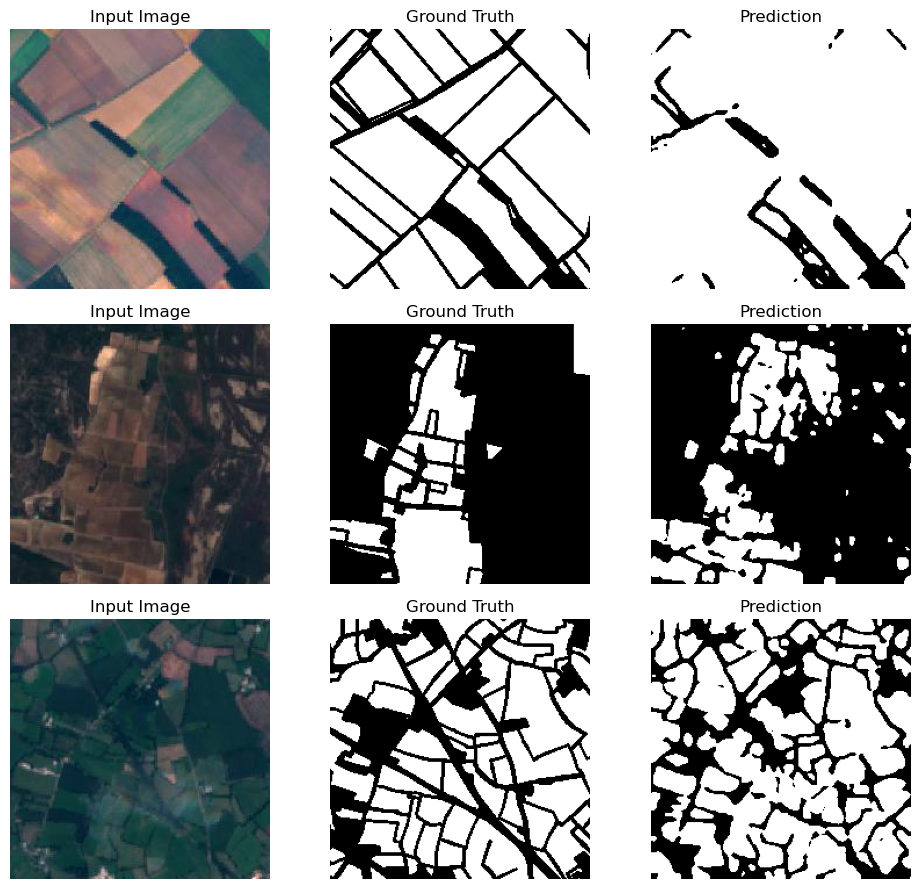

In [23]:
# Plotting Frozen
device="cuda"
encoder.eval()
decoder.eval()

images, masks = next(iter(test_loader))
images, masks = images.to(device), masks.to(device)
with torch.no_grad():
    encoder.to(device)
    decoder.to(device)
    outputs = decoder(encoder(images))
    preds = torch.sigmoid(outputs)
plot_predictions(images, masks, preds, invTrans, num_examples=3)

In [24]:
for (images, masks) in test_loader:
    print(len(images))

32
32
32
32
32
32


7. Compute error on test set


In [26]:
device="cuda:0"

criterion = metrics.load(metric_name = "softiouloss", device=device)
acc_metric = metrics.load(metric_name = "iou", device=device)

test(test_loader, encoder, decoder, criterion, acc_metric, device=device)

NameError: name 'test' is not defined